Step 1: Load the Data

In [102]:
# 1. Importing Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Step 2: Data Cleaning and Preprocessing

In [103]:
# 2. Load dataset into DataFrame

df = pd.read_csv('Train_data.csv')
print(df.shape)
df.head()

(7160, 14)


,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [104]:
# 3. Rename ambiguous columns

df.columns = [ "Customer_ID", "Year_Of_Observation", "Insured_Period", "Residential", "Building_painted", "Building_fenced",
    "Garden", "Settlement", "Building_Dimension", "Building_Type", "Date_Of_Occupancy", "Number_Of_Windows", "Geo_Code",
    "Claim" ]

In [105]:
# 4. Check for missing values

df.isnull().sum()

Customer_ID              0
Year_Of_Observation      0
Insured_Period           0
Residential              0
Building_painted         0
Building_fenced          0
Garden                   7
Settlement               0
Building_Dimension     106
Building_Type            0
Date_Of_Occupancy      508
Number_Of_Windows        0
Geo_Code               102
Claim                    0
dtype: int64

In [106]:
# 5. Fill categorical missing values with Unknown

cat_cols = ["Garden", "Geo_Code"]

for col in cat_cols:
    df[col] = df[col].astype("string")
    df[col] = df[col].fillna("Unknown")

In [107]:
# 6. Fill numerical missing values with Median

df["Date_Of_Occupancy"] = df["Date_Of_Occupancy"].fillna(df["Date_Of_Occupancy"].median())

df["Building_Dimension"] = pd.to_numeric(df["Building_Dimension"], errors="coerce")
df["Building_Dimension"] = df["Building_Dimension"].fillna(df["Building_Dimension"].median())


In [108]:
# 7. Final validation

df.isnull().sum()

Customer_ID            0
Year_Of_Observation    0
Insured_Period         0
Residential            0
Building_painted       0
Building_fenced        0
Garden                 0
Settlement             0
Building_Dimension     0
Building_Type          0
Date_Of_Occupancy      0
Number_Of_Windows      0
Geo_Code               0
Claim                  0
dtype: int64

In [109]:
# 8. Encode categorical variables

from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include="object").columns

le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col]).astype(str)

Step 3: Exploratory Data Analysis (EDA)

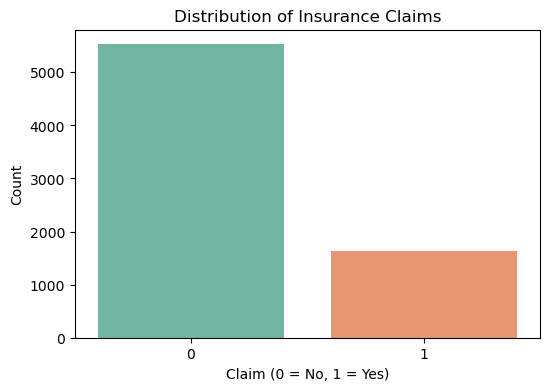

In [110]:
# 9. Target Variable Distribution 

plt.figure(figsize=(6,4))
sns.countplot(x="Claim", hue="Claim", data=df, palette="Set2", legend=False)
plt.title("Distribution of Insurance Claims")
plt.xlabel("Claim (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

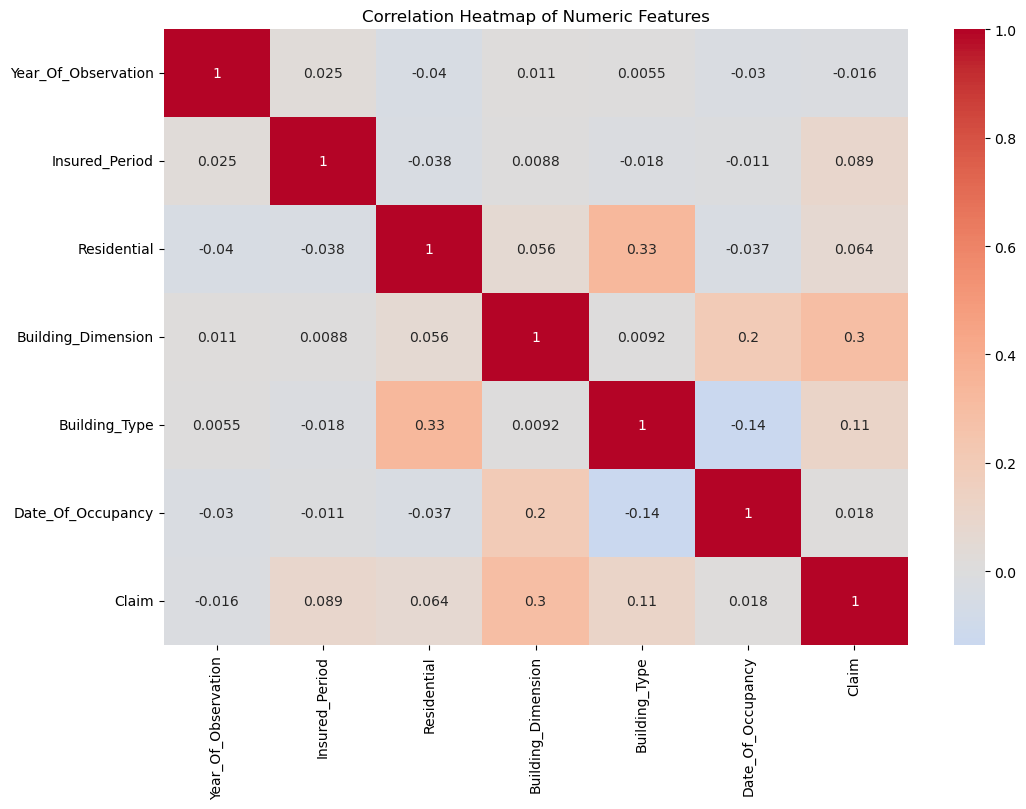

In [111]:
# 10. Correlation Heatmap

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

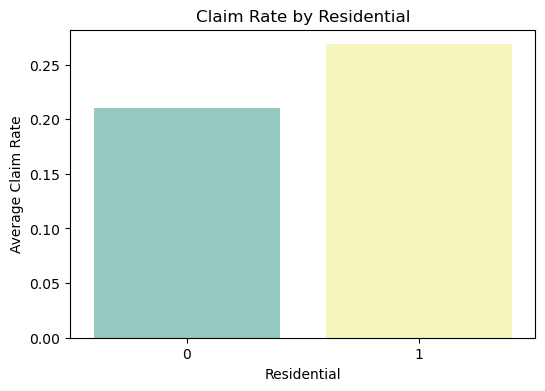

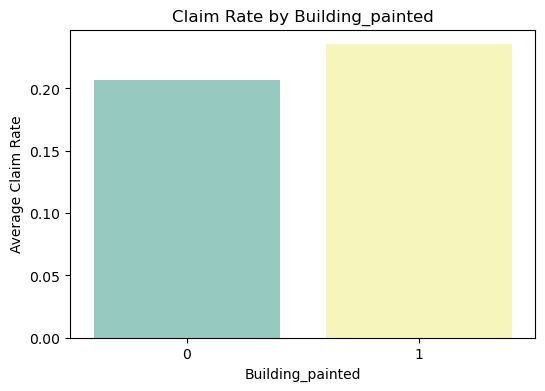

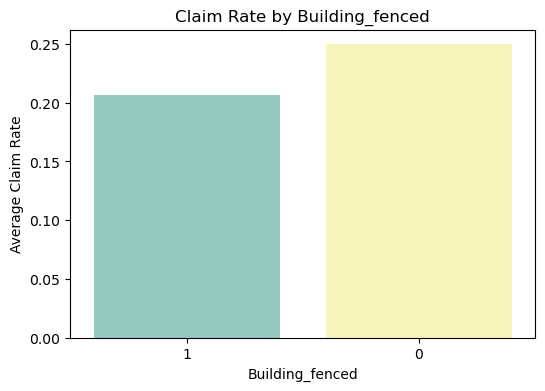

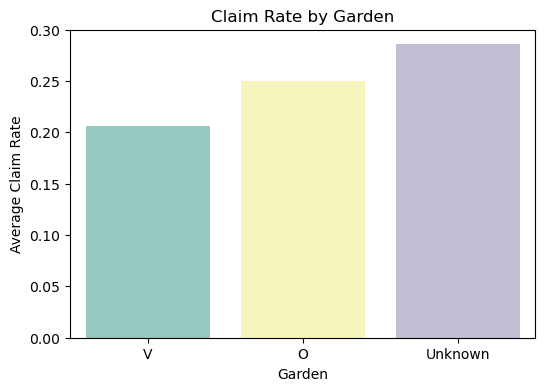

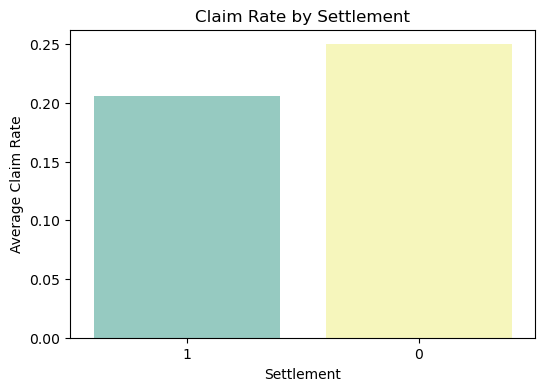

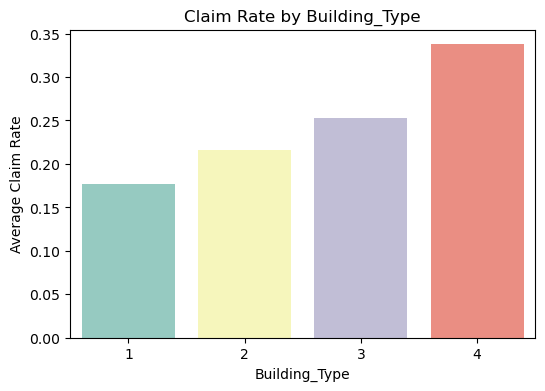

In [112]:
# 11. Claim Rate by Categorical Features 

categorical_features = ["Residential", "Building_painted", "Building_fenced", "Garden", "Settlement", "Building_Type"]

for col in categorical_features:
    plt.figure(figsize=(6,4))
    sns.barplot(x=col, y="Claim", hue=col, data=df, errorbar=None, palette="Set3", legend=False)
    plt.title(f"Claim Rate by {col}")
    plt.ylabel("Average Claim Rate")
    plt.show()


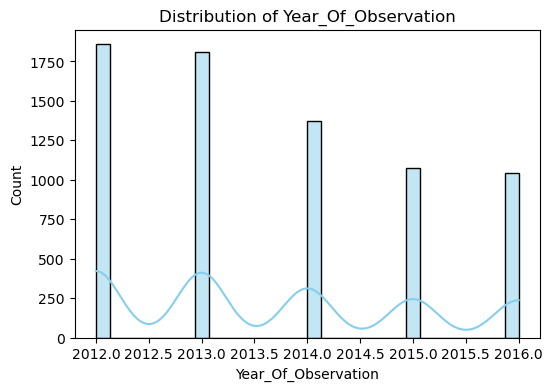

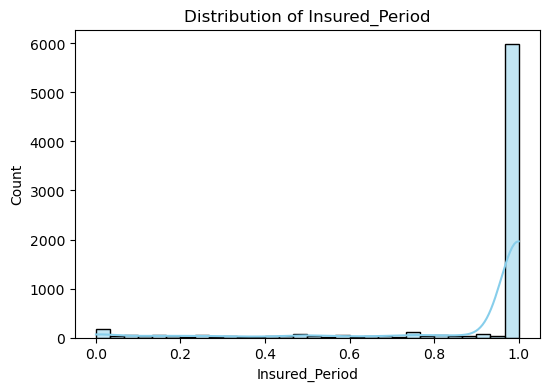

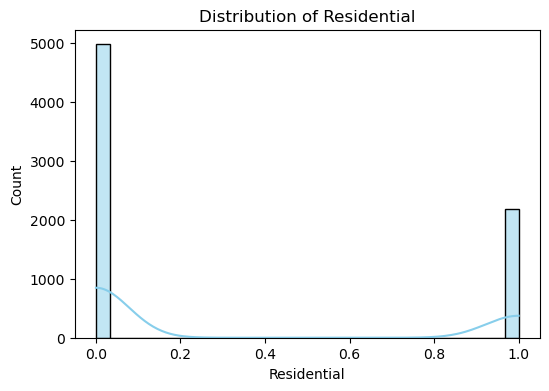

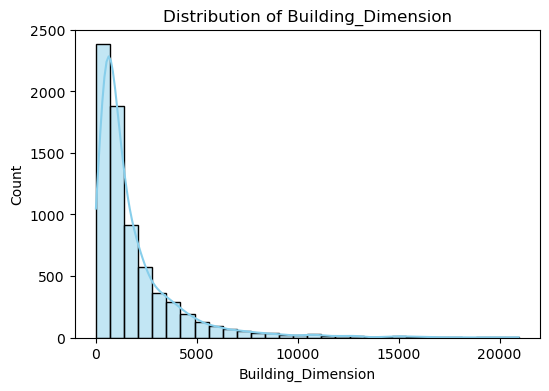

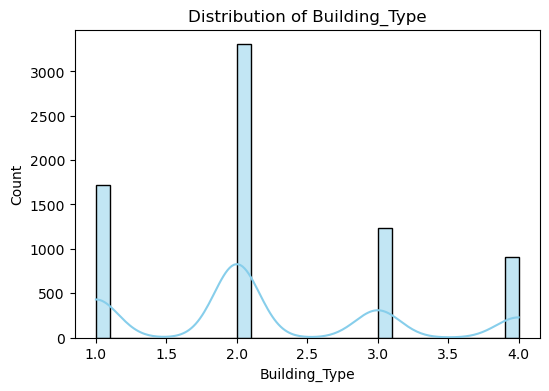

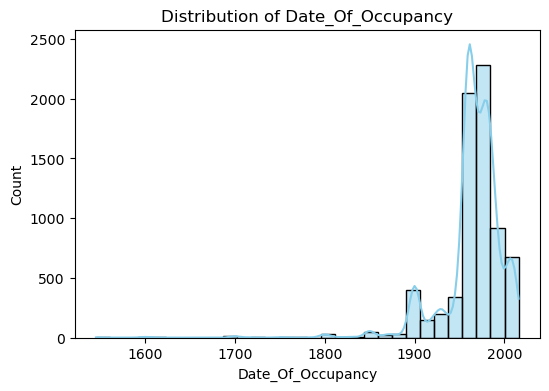

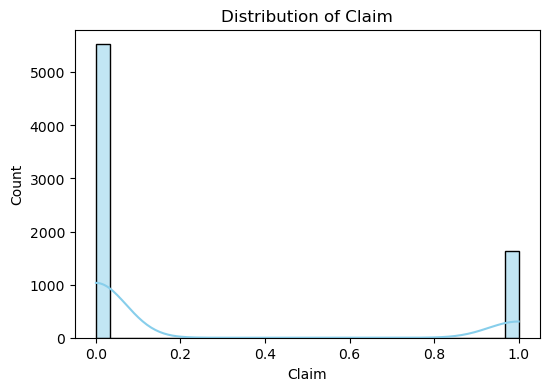

In [113]:
# 12. Distribution of Numerical Features 

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

for col in numeric_df: 
    plt.figure(figsize=(6,4)) 
    sns.histplot(df[col], kde=True, bins=30, color="skyblue") 
    plt.title(f"Distribution of {col}") 
    plt.show()

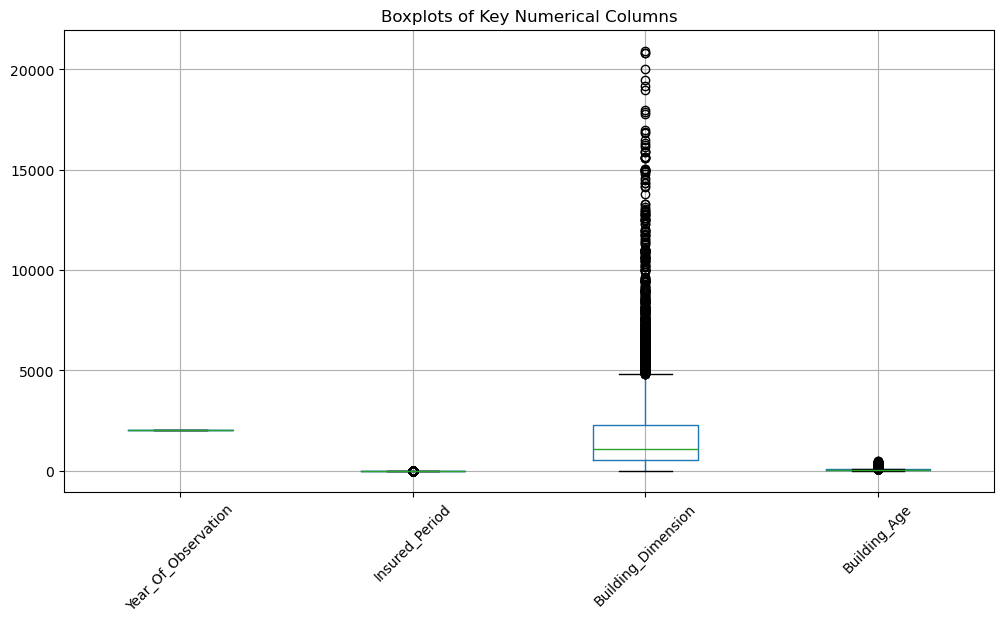

In [114]:
# 13. Boxplots for Outlier Detection 

df["Building_Age"] = df["Year_Of_Observation"] - df["Date_Of_Occupancy"]

num_cols = ["Year_Of_Observation", "Insured_Period", "Building_Dimension", "Building_Age"]

plt.figure(figsize=(12,6))
df[num_cols].boxplot(rot=45)
plt.title("Boxplots of Key Numerical Columns")
plt.show()

Exploratory analysis revealed meaningful variation in claim probability across several categorical variables such as settlement type, building fencing status, and building type.

The numerical feature analysis revealed that Building_Dimension contains significant outliers and skewness, suggesting the need for transformation to improve model performance.

 These insights guided preprocessing decisions and feature engineering for the predictive model.

Step 4: Data Preprocessing

In [115]:
# 14. Import libraries 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn.feature_selection import SelectKBest, f_classif 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

In [116]:
# 15. Transform Building_Dimension 

pt = PowerTransformer(method='yeo-johnson') 
df["Building_Dimension_transformed"] = pt.fit_transform(df[["Building_Dimension"]])
df = df.drop(columns=["Building_Dimension"])

In [119]:
# 16. Define features and target 

df = df.drop(columns=["Customer_ID"])
X = df.drop(columns=["Claim"]) # predictors 
y = df["Claim"] # target variable

In [120]:
# 17. Train-Test Split with stratification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
    stratify=y) # keeps the Claim distribution stable in train and test sets.

In [121]:
# 18. Identify categorical and numeric features

Numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
Categorical_features = X.select_dtypes(include=["object", "string"]).columns.tolist()

print("Categorical features:", Categorical_features) 
print("Numerical features:", Numerical_features)

Categorical features: ['Building_painted', 'Building_fenced', 'Garden', 'Settlement', 'Number_Of_Windows', 'Geo_Code']
Numerical features: ['Year_Of_Observation', 'Insured_Period', 'Residential', 'Building_Type', 'Date_Of_Occupancy', 'Building_Age', 'Building_Dimension_transformed']


In [123]:
# 19. To ensure column name match exactly

print("Available columns:", X_train.columns.tolist())

Available columns: ['Year_Of_Observation', 'Insured_Period', 'Residential', 'Building_painted', 'Building_fenced', 'Garden', 'Settlement', 'Building_Type', 'Date_Of_Occupancy', 'Number_Of_Windows', 'Geo_Code', 'Building_Age', 'Building_Dimension_transformed']


In [124]:
# 19. Build Preprocessing Pipeline

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])


preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, Numerical_features),
        ("cat", categorical_transformer, Categorical_features)])


Step 5: Model Building and Evaluation

In [125]:
# 20. Feature Selection + Models 

# Logistic Regression pipeline 
log_reg_pipeline = Pipeline([ ("preprocessor", preprocessor), 
    ("selector", SelectKBest(score_func=f_classif, k=10)), 
    ("classifier", LogisticRegression(max_iter=1000)) ]) 

# Random Forest pipeline 
rf_pipeline = Pipeline([ ("preprocessor", preprocessor), 
    ("selector", SelectKBest(score_func=f_classif, k=10)), 
    ("classifier", RandomForestClassifier(n_estimators=100, 
    random_state=42)) ]) 

# Gradient Boosting pipeline 
gb_pipeline = Pipeline([ ("preprocessor", preprocessor), 
    ("selector", SelectKBest(score_func=f_classif, k=10)), 
    ("classifier", GradientBoostingClassifier(n_estimators=100, 
    learning_rate=0.1, random_state=42)) ])

In [126]:
# 21. Train and Evaluate Models 

models = { "Logistic Regression": log_reg_pipeline, 
    "Random Forest": rf_pipeline, "Gradient Boosting": gb_pipeline } 

for name, model in models.items(): 
    print(f"\n {name}") 
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test) 
    y_proba = model.predict_proba(X_test)[:, 1] 
    
    print("Accuracy:", accuracy_score(y_test, y_pred)) 
    print("F1 Score:", f1_score(y_test, y_pred)) 
    print("ROC-AUC:", roc_auc_score(y_test, y_proba)) 
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred)) 
    print("Classification Report:\n", classification_report(y_test, y_pred))


 Logistic Regression
Accuracy: 0.7793296089385475
F1 Score: 0.25471698113207547
ROC-AUC: 0.689888884276364
Confusion Matrix:
 [[1062   43]
 [ 273   54]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87      1105
           1       0.56      0.17      0.25       327

    accuracy                           0.78      1432
   macro avg       0.68      0.56      0.56      1432
weighted avg       0.74      0.78      0.73      1432


 Random Forest
Accuracy: 0.736731843575419
F1 Score: 0.35111876075731496
ROC-AUC: 0.6339421866135304
Confusion Matrix:
 [[953 152]
 [225 102]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1105
           1       0.40      0.31      0.35       327

    accuracy                           0.74      1432
   macro avg       0.61      0.59      0.59      1432
weighted avg       0.72      0.74      0.72      1432



Confusion Matrix interpretation:
Logistic Regression (LR) is very conservative predicting claims (few positives predicted)

Random Forest predicts more claims than LR and Gradient Boosting and it is better at catching claims (highest recall 0.31)

Gradient Boosting has balanced conservative model with highest accuracy and reasonable ROC-AUC but still missing many claims (recall 0.22).

The dataset is imbalanced, support for Claim=0: 1105 while support for Claim=1: 327

So accuracy can look “good” even when the model is missing many claims. This is evident across models: low recall for Claim=1 (claims are being missed).

Step 6: Extending Pipelines with Class Balancing

In [130]:
#22. Pipelines with class_weight='balanced' 

log_reg_pipeline = Pipeline([ ("preprocessor", preprocessor), 
    ("selector", SelectKBest(score_func=f_classif, k=10)), 
    ("classifier", LogisticRegression(max_iter=1000, class_weight="balanced")) ])

rf_pipeline = Pipeline([ ("preprocessor", preprocessor), 
    ("selector", SelectKBest(score_func=f_classif, k=10)), 
    ("classifier", RandomForestClassifier(n_estimators=100, 
    random_state=42, class_weight="balanced")) ])

models = { "Logistic Regression (Balanced)": log_reg_pipeline, 
    "Random Forest (Balanced)": rf_pipeline}

for name, model in models.items(): 
    print(f"\n {name}") 
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test) 
    y_proba = model.predict_proba(X_test)[:, 1] 
    
    print("Accuracy:", accuracy_score(y_test, y_pred)) 
    print("F1 Score:", f1_score(y_test, y_pred)) 
    print("ROC-AUC:", roc_auc_score(y_test, y_proba)) 
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred)) 
    print("Classification Report:\n", classification_report(y_test, y_pred))


 Logistic Regression (Balanced)
Accuracy: 0.6571229050279329
F1 Score: 0.44769403824521936
ROC-AUC: 0.6895595500020757
Confusion Matrix:
 [[742 363]
 [128 199]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.67      0.75      1105
           1       0.35      0.61      0.45       327

    accuracy                           0.66      1432
   macro avg       0.60      0.64      0.60      1432
weighted avg       0.74      0.66      0.68      1432


 Random Forest (Balanced)
Accuracy: 0.7081005586592178
F1 Score: 0.36666666666666664
ROC-AUC: 0.630107794705744
Confusion Matrix:
 [[893 212]
 [206 121]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81      1105
           1       0.36      0.37      0.37       327

    accuracy                           0.71      1432
   macro avg       0.59      0.59      0.59      1432
weighted avg       0.71      0.71   

Balancing improved recall for claims across both models.

Logistic Regression benefited the most, showing a big jump in recall (from 0.17 to 0.61).

Accuracy dropped because the models are now more willing to classify borderline cases as claims, which is exactly what you want when claims are rare but important.

Random Forest improved slightly, but its ROC-AUC remains weaker than Logistic Regression.

Step 7: Hyperparameter tuning for Random Forest and Gradient Boosting

In [131]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

# 23. Random Forest Randomized Search

rf_params = {
    "classifier__n_estimators": randint(100, 500),        # number of trees
    "classifier__max_depth": [None] + list(range(5, 30, 5)),
    "classifier__min_samples_split": randint(2, 20),
    "classifier__min_samples_leaf": randint(1, 10),
    "classifier__max_features": ["sqrt", "log2", None],
    "classifier__class_weight": ["balanced"]}

rf_random = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_params,
    n_iter=30,  # number of random combinations to try
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",   # optimize for F1 score (claims detection)
    n_jobs=-1,
    random_state=42,
    verbose=2)

rf_random.fit(X_train, y_train)
print("Best Random Forest Params:", rf_random.best_params_)
print("Best RF F1 Score:", rf_random.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Random Forest Params: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 15, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 291}
Best RF F1 Score: 0.47737465093922776


In [132]:
# 24. Gradient Boosting Randomized Search

gb_params = {
    "classifier__n_estimators": randint(100, 500),
    "classifier__learning_rate": uniform(0.01, 0.2),       # sample between 0.01–0.21
    "classifier__max_depth": randint(3, 10),
    "classifier__subsample": uniform(0.7, 0.3),            # sample between 0.7–1.0
    "classifier__min_samples_split": randint(2, 20),
    "classifier__min_samples_leaf": randint(1, 10)}

gb_random = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=gb_params,
    n_iter=30,
    cv=StratifiedKFold(n_splits=5),
    scoring="f1",
    n_jobs=-1,
    random_state=42,
    verbose=2)

gb_random.fit(X_train, y_train)
print("Best Gradient Boosting Params:", gb_random.best_params_)
print("Best GB F1 Score:", gb_random.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Gradient Boosting Params: {'classifier__learning_rate': 0.11171413823294056, 'classifier__max_depth': 8, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 336, 'classifier__subsample': 0.8619523273905019}
Best GB F1 Score: 0.3556662487961384


In [136]:
#25. Retrain Random Forest with best params
rf_best = RandomForestClassifier(n_estimators=291, max_depth=15,
    max_features="log2", min_samples_leaf=6, min_samples_split=3,
    class_weight="balanced", random_state=42)

# Retrain Gradient Boosting with best params
gb_best = GradientBoostingClassifier(n_estimators=336,
    learning_rate=0.11171413823294056,
    max_depth=8, min_samples_leaf=5, min_samples_split=8,
    subsample=0.8619523273905019, random_state=42)

# Convert categorical variables to numerical using one-hot encoding or label encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical columns (this is an example - adjust based on your actual data)
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Create pipelines with preprocessing
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_best)
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', gb_best)
])

# Fit models with preprocessing
rf_pipeline.fit(X_train, y_train)
gb_pipeline.fit(X_train, y_train)

# Evaluate both tuned models
for name, model in [("Random Forest (Tuned)", rf_pipeline), ("Gradient Boosting (Tuned)", gb_pipeline)]:
    print(f"\n {name}")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))


 Random Forest (Tuned)
Accuracy: 0.7115921787709497
F1 Score: 0.4287690179806362
ROC-AUC: 0.6926896093652706
Confusion Matrix:
 [[864 241]
 [172 155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81      1105
           1       0.39      0.47      0.43       327

    accuracy                           0.71      1432
   macro avg       0.61      0.63      0.62      1432
weighted avg       0.73      0.71      0.72      1432


 Gradient Boosting (Tuned)
Accuracy: 0.7562849162011173
F1 Score: 0.3427495291902072
ROC-AUC: 0.6636362378402314
Confusion Matrix:
 [[992 113]
 [236  91]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85      1105
           1       0.45      0.28      0.34       327

    accuracy                           0.76      1432
   macro avg       0.63      0.59      0.60      1432
weighted avg       0.73      0.76      0.73  

Random Forest (Tuned) is better at our priority of detecting claims (higher recall, better F1).

Gradient Boosting (Tuned) is better for priority of overall accuracy and minimizing false positives.

Both models improved compared to untuned versions, but they optimize different trade-offs.

Step 8: Save Model

In [140]:
import joblib

#26. Save pipeline 

# Bundle both pipelines into one object 
final_models = { 
    "RandomForest": rf_pipeline, 
    "GradientBoosting": gb_pipeline
}

# Save as one .pkl file 
joblib.dump(final_models, "claim_prediction_models.pkl")
print("Claim_prediction_models saved successfully!")

Claim_prediction_models saved successfully!


In this project, I developed a predictive model to estimate the probability of an insurance claim occurring for a building during its insured period. 

After performing data cleaning, handling missing values, exploratory data analysis, and feature engineering, multiple machine learning models were trained and evaluated.

Random Forest and Gradient Boosting achieved the best performance and the final model was saved for future deployment.